In [39]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [40]:
# Paso 2: Descargar HTML
# Seleccionar el recurso a descargar
resource_url =  "https://companies-market-cap-copy.vercel.app/index.html"

In [41]:
# Petición para descargar el fichero de Internet
response = requests.get(resource_url)
#print( response.status_code)

In [42]:
html_content = response.text  # convertir a texto

In [43]:
soup = BeautifulSoup (html_content, features="html.parser") # PARSER: analizar y convertir datos estructurados (como texto)
soup
#print(soup)


<!DOCTYPE html>

<html lang="en-US">
<head>
<title>Tesla (TSLA) - Revenue</title>
<meta charset="utf-8"/>
<link href="https://companiesmarketcap.com/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/img/icons/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
<link href="/img/icons/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
<link href="/img/icons/apple-icon-72x72.png" rel="apple-touch-icon" sizes="72x72"/>
<link href="/img/icons/apple-icon-76x76.png" rel="apple-touch-icon" sizes="76x76"/>
<link href="/img/icons/apple-icon-114x114.png" rel="apple-touch-icon" sizes="114x114"/>
<link href="/img/icons/apple-icon-120x120.png" rel="apple-touch-icon" sizes="120x120"/>
<link href="/img/icons/apple-icon-144x144.png" rel="apple-touch-icon" sizes="144x144"/>
<link href="/img/icons/apple-icon-152x152.png" rel="apple-touch-icon" sizes="152x152"/>
<link href="/img/icons/apple-icon-180x180.png" rel="apple-touch-icon" sizes="180x180"/>
<link href="/img/ic

In [44]:
#Buscar todas las tablas.
table = soup.find("table")  
table

<table class="table" style="width:100%">
<thead>
<tr>
<th>Year</th>
<th>Revenue</th>
<th>Change</th>
</tr>
</thead>
<tbody>
<tr><td><span class="year">2024</span></td><td>$97.15 B</td><td class="percentage-green">0.39%</td></tr><tr><td><span class="year">2023</span> </td><td>$96.77 B</td><td class="percentage-green">18.8%</td></tr><tr><td><span class="year">2022</span></td><td>$81.46 B</td><td class="percentage-green">51.35%</td></tr><tr><td><span class="year">2021</span></td><td>$53.82 B</td><td class="percentage-green">70.67%</td></tr><tr><td><span class="year">2020</span></td><td>$31.53 B</td><td class="percentage-green">28.31%</td></tr><tr><td><span class="year">2019</span></td><td>$24.57 B</td><td class="percentage-green">14.52%</td></tr><tr><td><span class="year">2018</span></td><td>$21.46 B</td><td class="percentage-green">82.51%</td></tr><tr><td><span class="year">2017</span></td><td>$11.75 B</td><td class="percentage-green">67.98%</td></tr><tr><td><span class="year">2016</span

# Almacena los datos en un DataFrame.

In [45]:

database = []                                           
for row in tqdm(table.findAll('tr')[1:]):  #tqdm, sigue el avance de las tareas que requieren mucho tiempo
    year = row.findAll('td')[0].find('span').text.strip() 
    revenue = row.findAll('td')[1].text.strip().replace('$', '').replace('B', '').strip() #limpia las filas para obtener los valores limpios eliminando $ y B
    database.append([year, revenue])

database

100%|██████████| 16/16 [00:00<00:00, 20213.51it/s]


[['2024', '97.15'],
 ['2023', '96.77'],
 ['2022', '81.46'],
 ['2021', '53.82'],
 ['2020', '31.53'],
 ['2019', '24.57'],
 ['2018', '21.46'],
 ['2017', '11.75'],
 ['2016', '7.00'],
 ['2015', '4.04'],
 ['2014', '3.19'],
 ['2013', '2.01'],
 ['2012', '0.41'],
 ['2011', '0.20'],
 ['2010', '0.11'],
 ['2009', '0.11']]

In [46]:
df1 = pd.DataFrame(database, columns=["Year", "Revenue"])
df1 = df1.sort_values("Year", ascending=False)

In [47]:
print(df1)

    Year Revenue
0   2024   97.15
1   2023   96.77
2   2022   81.46
3   2021   53.82
4   2020   31.53
5   2019   24.57
6   2018   21.46
7   2017   11.75
8   2016    7.00
9   2015    4.04
10  2014    3.19
11  2013    2.01
12  2012    0.41
13  2011    0.20
14  2010    0.11
15  2009    0.11


Paso 5: Almacena los datos en sqlite

In [52]:
import sqlite3

conn = sqlite3.connect("revenues.db")
cur = conn.cursor()   # create a Cursor object 


In [53]:
#CREATE TABLE IF NOT EXISTS revenues;     Crear tabla si no existe, esto permite ejecutar sin problemas varias veces
# Year INTEGER PRIMARY KEY,;   La clave primaria en Year me garantiza que cada fila en la tabla sea única y no hayan mas registros de ese año.

cur.execute('''
    CREATE TABLE IF NOT EXISTS revenues (
        Year INTEGER PRIMARY KEY,
        Revenue REAL
    )
''')


In [54]:
#Insertar datos 

for index, row in df1.iterrows():
    cur.execute('''
        INSERT INTO revenues (Year, Revenue)
        VALUES (?, ?)
        ON CONFLICT(Year) DO UPDATE SET Revenue=excluded.Revenue
    ''', (int(row["Year"]), float(row["Revenue"])))

OperationalError: database is locked

In [55]:
# Confirmar (commit) los cambios
conn.commit()

# Comprobar el contenido de la tabla
cur.execute("SELECT * FROM revenues")
rows = cur.fetchall()
for row in rows:
    print(row)

# Cerrar la conexión
conn.close()

(2009, 0.11)
(2010, 0.11)
(2011, 0.2)
(2012, 0.41)
(2013, 2.01)
(2014, 3.19)
(2015, 4.04)
(2016, 7.0)
(2017, 11.75)
(2018, 21.46)
(2019, 24.57)
(2020, 31.53)
(2021, 53.82)
(2022, 81.46)
(2023, 96.77)
(2024, 97.15)


In [27]:
conn.close()

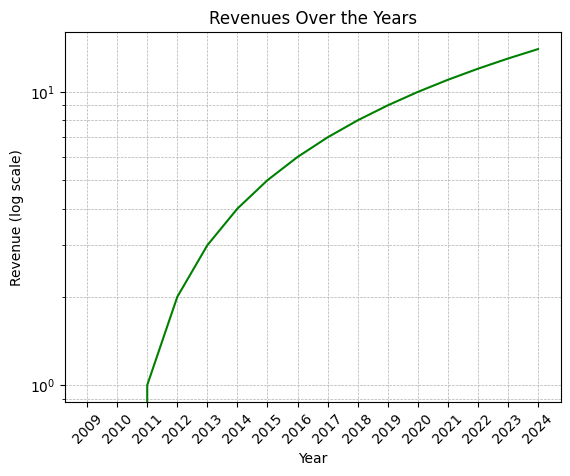

In [63]:
#Invierto el df para que la vizualisacion sea más logica y que me enseñe del 2009 a 2024 y no el contrario : 
df_asc = df1[::-1].reset_index(drop=True)

plt.plot(df_asc['Year'], df_asc['Revenue'], color='green')
plt.yscale('log')  # Escala logarítmica en Y
plt.title('Revenues Over the Years')
plt.xlabel('Year')
plt.ylabel('Revenue (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Mejora la visibilidad del grid
plt.tick_params(axis='x', rotation=45)
plt.show()

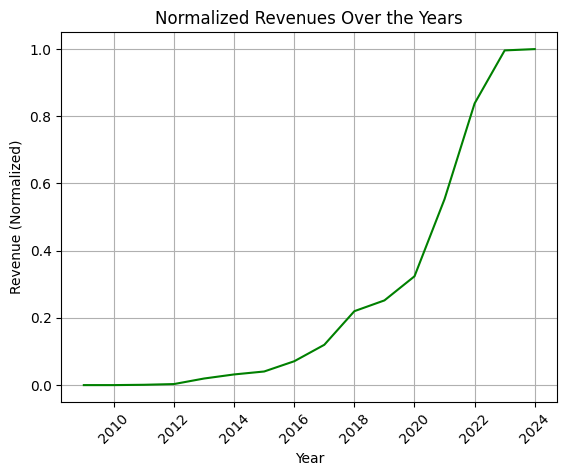

In [68]:
#Datos numéricos
df_asc['Revenue'] = pd.to_numeric(df_asc['Revenue'], errors='coerce')
df_asc['Year'] = pd.to_numeric(df_asc['Year'], errors='coerce')  

#Normalizar
df_asc['Revenue_normalized'] = (df_asc['Revenue'] - df_asc['Revenue'].min()) / (df_asc['Revenue'].max() - df_asc['Revenue'].min())

# Graficar
plt.plot(df_asc['Year'], df_asc['Revenue_normalized'], color='green')
plt.xlabel('Year')
plt.ylabel('Revenue (Normalized)')
plt.title('Normalized Revenues Over the Years')
plt.grid(True)
plt.tick_params(axis='x', rotation=45)
plt.show()



In [19]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Paso 2: Descargar HTML
# Seleccionar el recurso a descargar
resource_url =  "https://companies-market-cap-copy.vercel.app/earnings.html"


# Petición para descargar el fichero de Internet
response = requests.get(resource_url)
#print( response.status_code)

html_content = response.text  # convertir a texto

# Transformamos el HTML plano en un HTML real (estructurado y anidado, con forma de árbol)

soup = BeautifulSoup (html_content, features="html.parser") # PARSER: analizar y convertir datos estructurados (como texto)
soup
#print(soup)

#Buscar todas las tablas.
table = soup.find("table")  
table


#Almacena los datos en un DataFrame.
database2 = []                                           
for row in tqdm(table.findAll('tr')[1:]):
    year = row.findAll('td')[0].find('span').text.strip() 
    earnings_i = row.findAll('td')[1].text.strip()
    earnings_1=earnings_i.replace('$', '').replace(' ', '').replace('Billion', '').replace('Million', '').replace('B', '').replace('M', '')
    if 'B' or 'Billion' in earnings_i:
        earnings= float(earnings_1)*1e9
    elif 'M' or 'Million' in earnings_i:
        earnings= float(earnings_1)*1e6
    else: 
        earnings=float(earnings_1)
      
    database2.append([year, earnings])

#print(database)

df = pd.DataFrame(database2, columns=["Year", "Earnings"])
df = df.sort_values("Year", ascending=False)

print(df)


#Paso 5: Almacena los datos en sqlite
import sqlite3

conn2 = sqlite3.connect("earnings.db")
cur2 = conn2.cursor()   # create a Cursor object

#CREATE TABLE IF NOT EXISTS earnings;     Crear tabla si no existe, esto permite ejecutar sin problemas varias veces
# Year INTEGER PRIMARY KEY,;   La clave primaria en Year me garantiza que cada fila en la tabla sea única y no hayan mas registros de ese año.

cur2.execute('''
    CREATE TABLE IF NOT EXISTS earnings (
        Year INTEGER PRIMARY KEY,
        Earnings REAL
    )
''')

#Insertar datos 

for index, row in df.iterrows():
    cur2.execute('''
        INSERT INTO earnings (Year, Earnings)
        VALUES (?, ?)
        ON CONFLICT(Year) DO UPDATE SET Earnings=excluded.Earnings
    ''', (int(row["Year"]), float(row["Earnings"])))


# Confirmar (commit) los cambios
conn2.commit()

# Comprobar el contenido de la tabla
cur2.execute("SELECT * FROM earnings")
rows = cur2.fetchall()
for row in rows:
    print(row)

# Cerrar la conexión
conn2.close()

100%|██████████| 16/16 [00:00<00:00, 34361.94it/s]

    Year      Earnings
0   2024  8.730000e+09
1   2023  1.012000e+10
2   2022  1.391000e+10
3   2021  6.710000e+09
4   2020  1.900000e+09
5   2019  2.000000e+10
6   2018 -3.500000e+08
7   2017 -1.740000e+09
8   2016 -5.500000e+08
9   2015 -7.600000e+08
10  2014 -1.900000e+08
11  2013 -3.848000e+10
12  2012 -4.000000e+08
13  2011 -2.600000e+08
14  2010 -1.600000e+08
15  2009 -5.319000e+10
(2009, -53190000000.0)
(2010, -160000000.0)
(2011, -260000000.0)
(2012, -400000000.0)
(2013, -38480000000.0)
(2014, -190000000.0)
(2015, -760000000.0)
(2016, -550000000.0)
(2017, -1740000000.0)
(2018, -350000000.0)
(2019, 20000000000.0)
(2020, 1900000000.0)
(2021, 6710000000.0)
(2022, 13910000000.0)
(2023, 10120000000.0)
(2024, 8730000000.0)


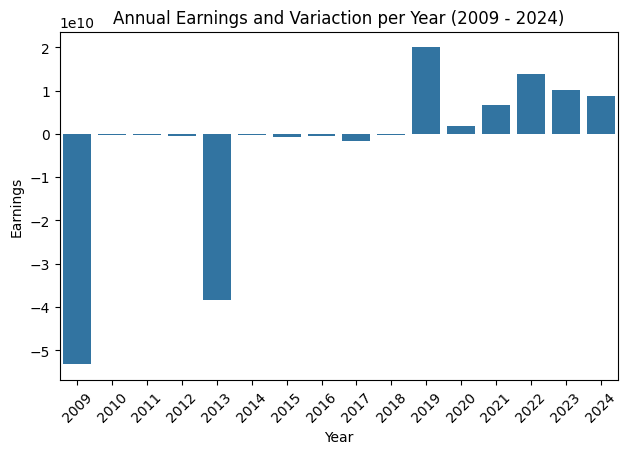

In [20]:
#Invierto el df para que la vizualisacion sea más logica y que me enseñe del 2009 a 2024 y no el contrario : 
df_asc = df[::-1].reset_index(drop=True)

# Barras para Earnings
sns.barplot(x='Year', y='Earnings', data=df_asc)
plt.title('Annual Earnings and Variaction per Year (2009 - 2024)')
plt.xlabel('Year')
plt.ylabel('Earnings')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()